# 940pts-EFS-55CpGs

## Where the data at?

In [1]:
import pandas as pd
import sys
sys.path.append('../')

mount = '/mnt/d/'
input_path = '/mnt/d/MethylScore/Intermediate_Files/'
output_path = '/mnt/d/MethylScore/Processed_Data/'
zhou2016_probes_path = '/mnt/d/MethylScore/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

## Load Data

In [2]:
# read top CpGs selected from previous code file (univariate cox-ph EWAS)
ewas_top_cpgs = pd.read_csv(output_path+'ewas_dmr/ewas_top_cpgs_efs.csv', index_col=0)

# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0).loc[ewas_top_cpgs.index]

# save clinical data
discovery_clinical_data.to_excel('../data/ewas_top_cpgs_clinical_data_discovery.xlsx')

print(
    f' Dataset (df) contains {ewas_top_cpgs.shape[1]} columns (5mC nucleotides/probes) and {ewas_top_cpgs.shape[0]} rows (samples).')

 Dataset (df) contains 112 columns (5mC nucleotides/probes) and 940 rows (samples).


## Standardize Data

Standardize the data so that mean becomes 0 and standard deviation becomes 1.

This is done to avoid biasing the model towards features with large values.

In [3]:
def standardize_data(df, reference_df):
    """Standardize data using mean and standard deviation of reference dataset"""

    # Keep only columns that are in both datasets
    reference_df = reference_df.loc[:, df.columns]

    # Standardize data
    df = (df - reference_df.mean()) / reference_df.std()

    return df

# Standardize data
x_train_m_z = standardize_data(df= ewas_top_cpgs, reference_df= ewas_top_cpgs)

# Save standardized data
# x_test_m_z.to_excel('../data/ewas_top_167_cpgs_M-Values_standardized_discovery_cohort.xlsx')

## Perform multivariate CoxPH-Lasso

In [4]:
# Import functions to clean up clinical data
import sys
sys.path.append('../')
from source.cox_lasso_functions import *

# Run Cox-Lasso
raw_coefs = train_coxph_lasso(df=discovery_clinical_data,
                                event= 'efs.evnt',
                                time= 'efs.time',
                                train_x= x_train_m_z,
                                cv_n_split=10,
                                loops=10)
raw_coefs.to_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs_newrisk_efs.csv')


raw_coefs = pd.read_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs_newrisk_efs.csv', index_col=0)

Running Cox-Lasso through 10 loops:


  0%|          | 0/10 [00:00<?, ?it/s]/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/fmarchi/projects/MethylScore/Code/.v

Cox-Lasso Trained Successfuly!
Selected alpha value: [0.013894667175673019]


### Set Threshold

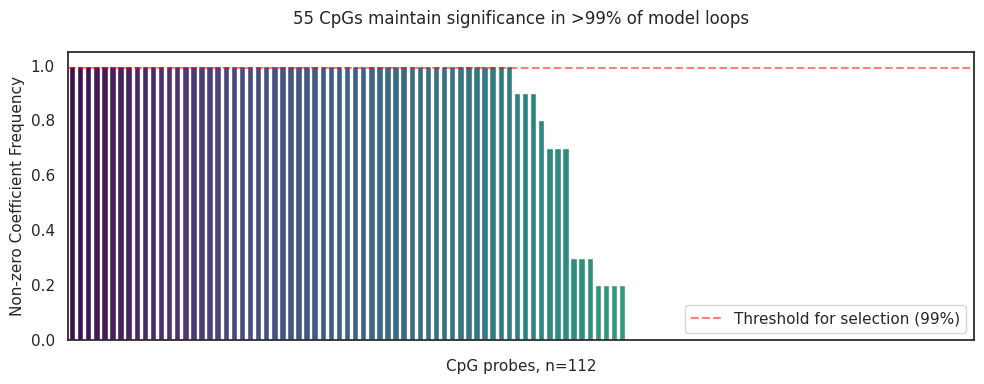

In [5]:
mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.99)
                                
plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.99, savefig=False, fig_path=None, figsize=(10,4))


### Save table of CpGs coefficients with EWAS results

In [6]:
# Load `ewas_cpgs_top_OS_with_EFSinfo.xlsx`
# ewas_cpgs_top_OS_with_EFSinfo = pd.read_excel('../data/ewas_cpgs_top_OS_with_EFSinfo.xlsx', index_col=0)\
#     .join(mean_coefs.to_frame('MethylScoreAML Px Coefs')).sort_values('MethylScoreAML Px Coefs', ascending=False)\
#         .to_excel('../data/ewas_cpgs_top_OS_with_EFSinfo_with_MethylScoreAML_Px_Coefs.xlsx')

## Generate Model Results

### Discovery Dataset

In [7]:
score_name = 'MethylScore55_NewRiskEFS'

df, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x_train_m_z,
                                        df=discovery_clinical_data,
                                        score_name=score_name,
                                        train_test="train",
                                        rpart_outcome='efs.time')

# df.to_excel(output_path + 'multivariate_cox_lasso/ewas_cog_efs_MethylScoreAML_Px_efs.xlsx')

Continuous score cut at the value of 0.1934


Text(0.5, 1.0, 'Distribution of MethylScore55_NewRiskEFS in COG trials')

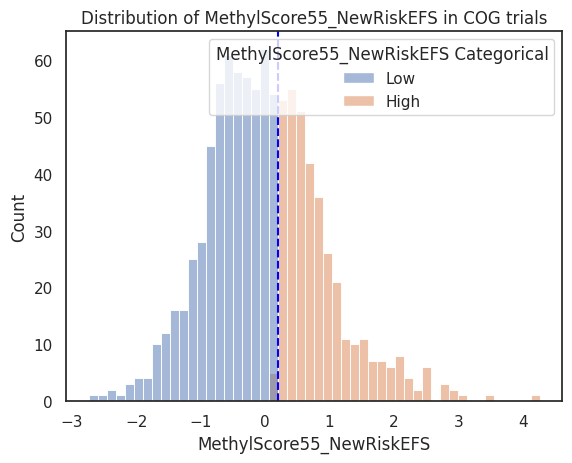

In [8]:
sns.histplot(data=df,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='blue', linestyle='--')


# add legend
plt.title('Distribution of ' + score_name + ' in COG trials')

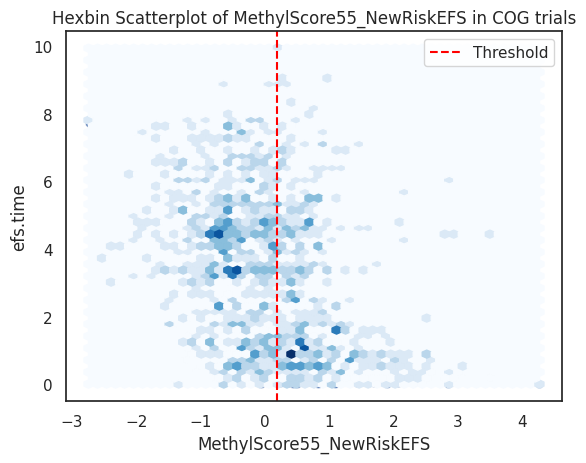

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# create scatterplot 
sns.scatterplot(data=df, x=score_name, y='efs.time', alpha=0.8)

# use hexbin plot to show density
ax = plt.gca()
ax.hexbin(df[score_name], df['os.time'], gridsize=50, cmap='Blues')

# add title
plt.title('Hexbin Scatterplot of {} in COG trials'.format(score_name)) 

# add vertical line at threshold
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()

# save plot as png
# plt.savefig(path + '/Hexbin_Scatterplot_{}_efs.time_{}.png'.format(score_name, len(df)), 
#             bbox_inches='tight', dpi=300)

plt.show()

### Kaplan-Meier Plots

#### Overall study population

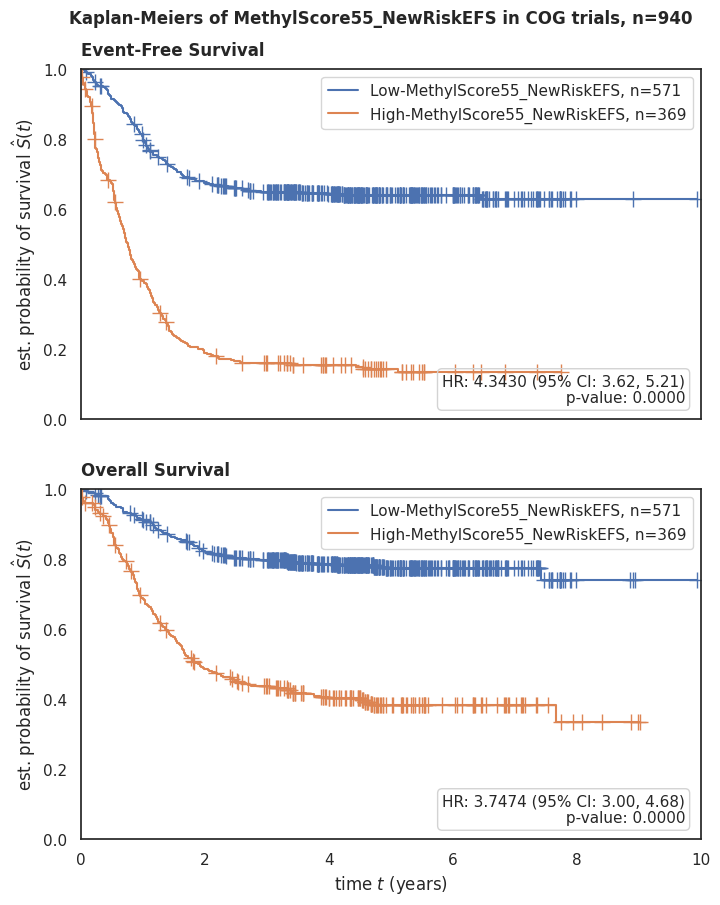

In [10]:
# Import Plotting Functions
from source.data_visualization_functions import *

draw_kaplan_meier(scorename=score_name,
                        df=df,
                        save_plot=False,
                        save_survival_table=True,
                        add_risk_counts=False,
                        trialname='COG trials')

#### Per risk group

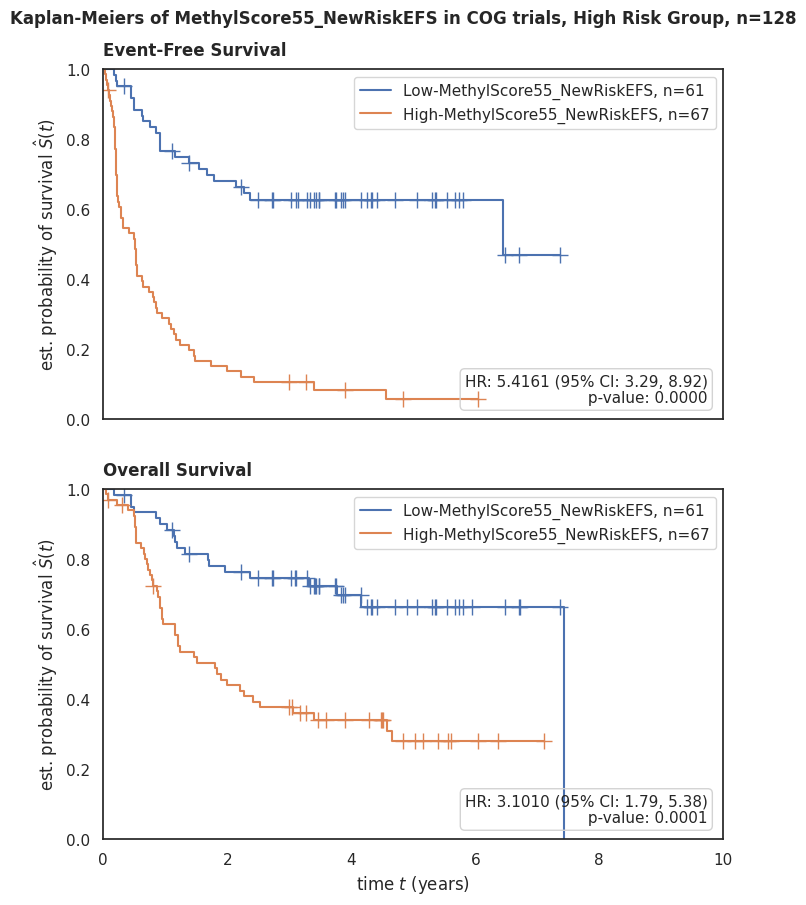

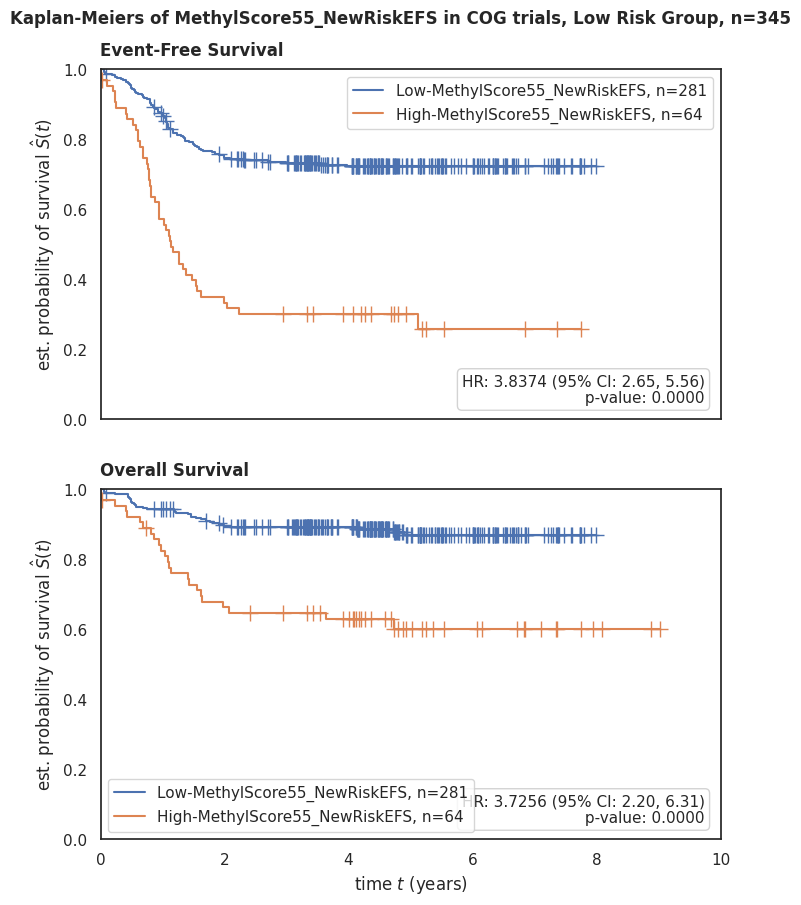

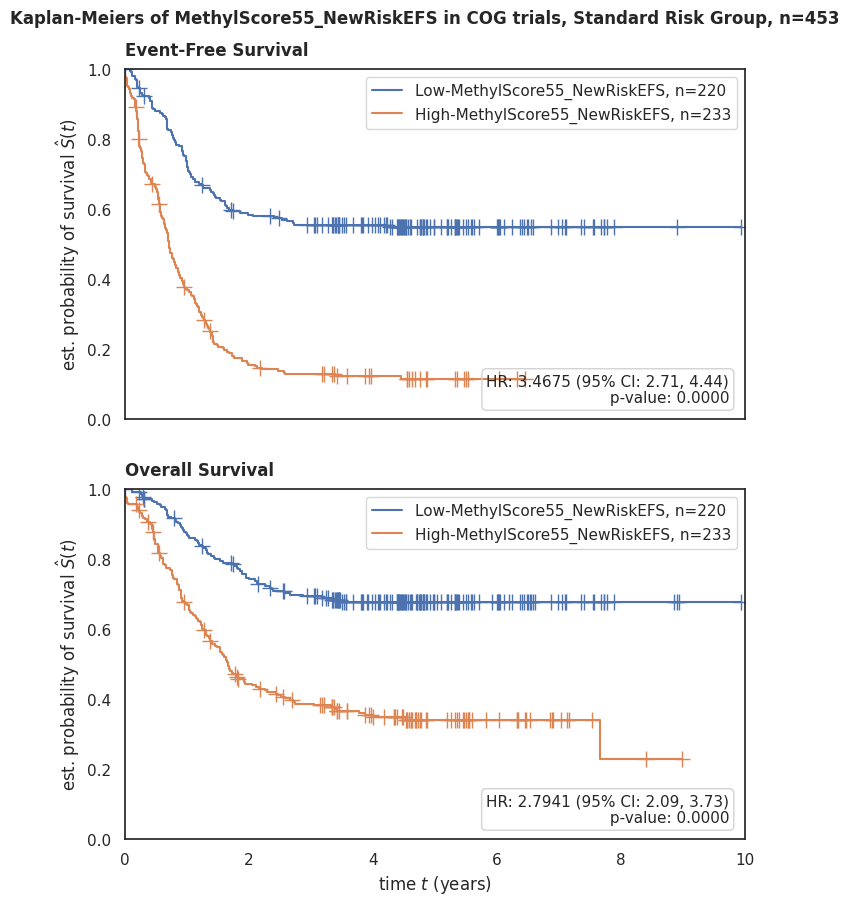

In [11]:
draw_kaplan_meier(scorename=score_name,
                        df=df[df['Risk Group'] == 'High Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='COG trials, High Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df[df['Risk Group'] == 'Low Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='COG trials, Low Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df[df['Risk Group'] == 'Standard Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='COG trials, Standard Risk Group')

#### Updated risk group

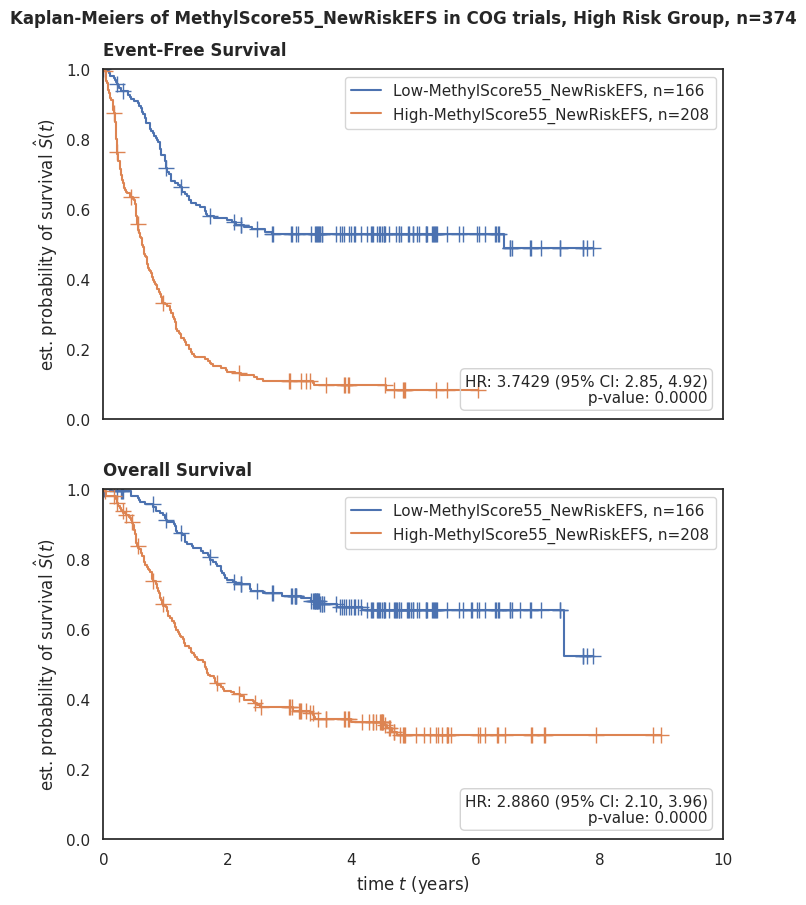

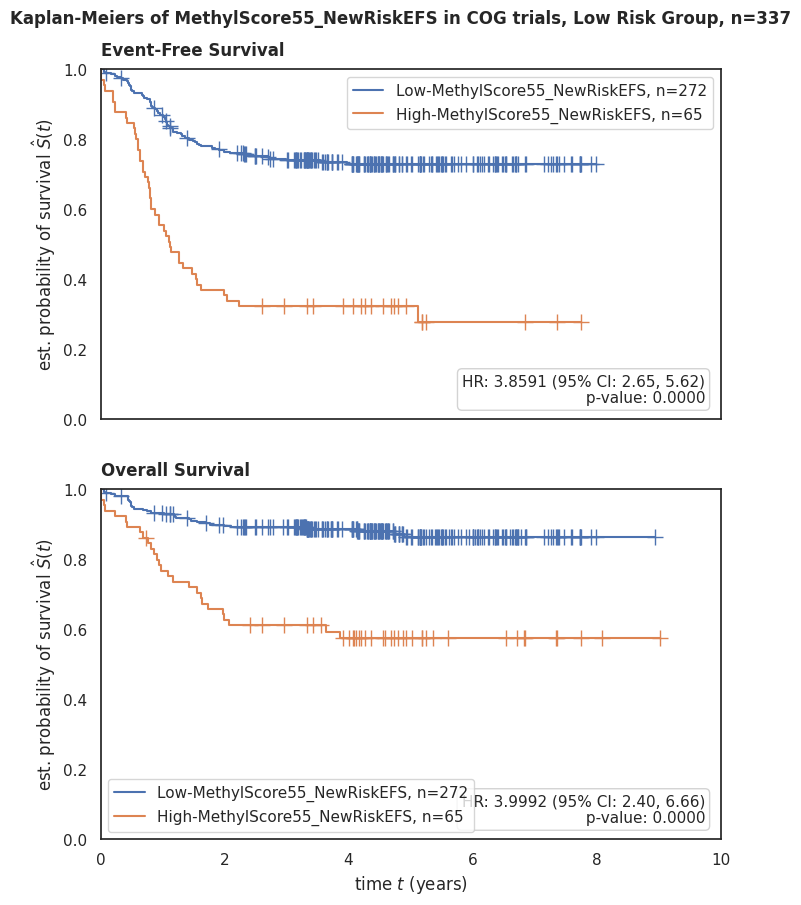

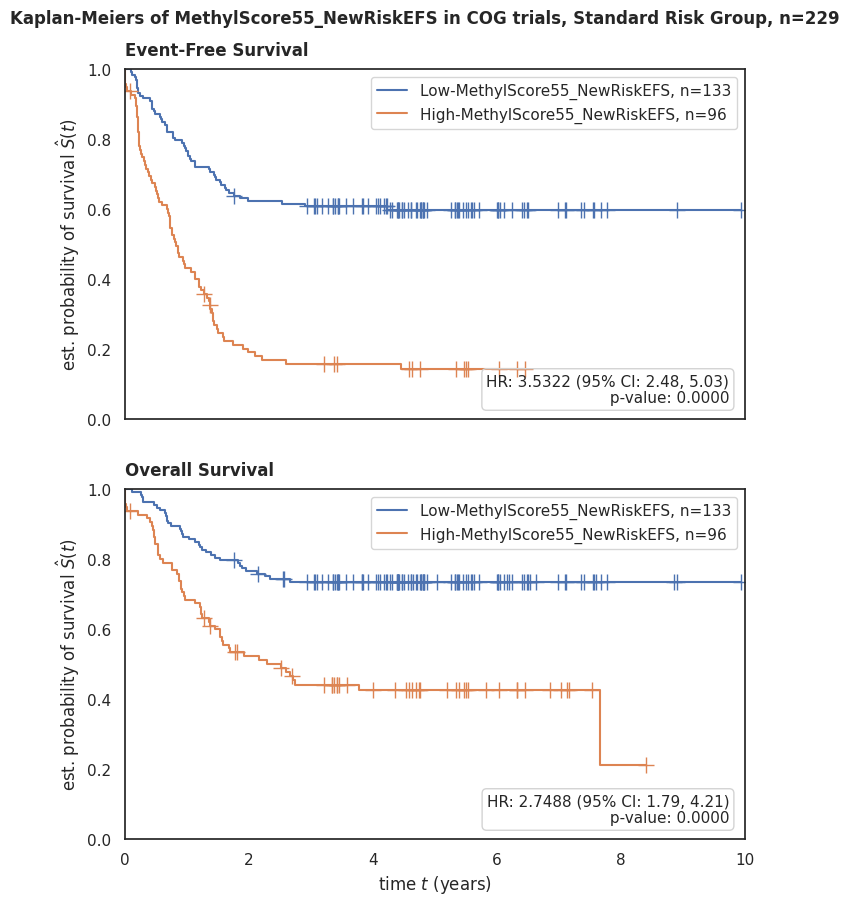

In [12]:
new_risk = pd.read_csv(input_path + 'updated_risk_group_COG_RR_1-10-2024/COG_risk_added_v2_cleanedFM.csv',
                       index_col=0,)
                       
df2 = df.join(new_risk[['Cyto/Molecular Risk']])

draw_kaplan_meier(scorename=score_name,
                        df=df2[df2['Cyto/Molecular Risk'] == 'High'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='COG trials, High Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df2[df2['Cyto/Molecular Risk'] == 'Low'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='COG trials, Low Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df2[df2['Cyto/Molecular Risk'] == 'Standard'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='COG trials, Standard Risk Group')

### Forest Plots

#### With MRD 1

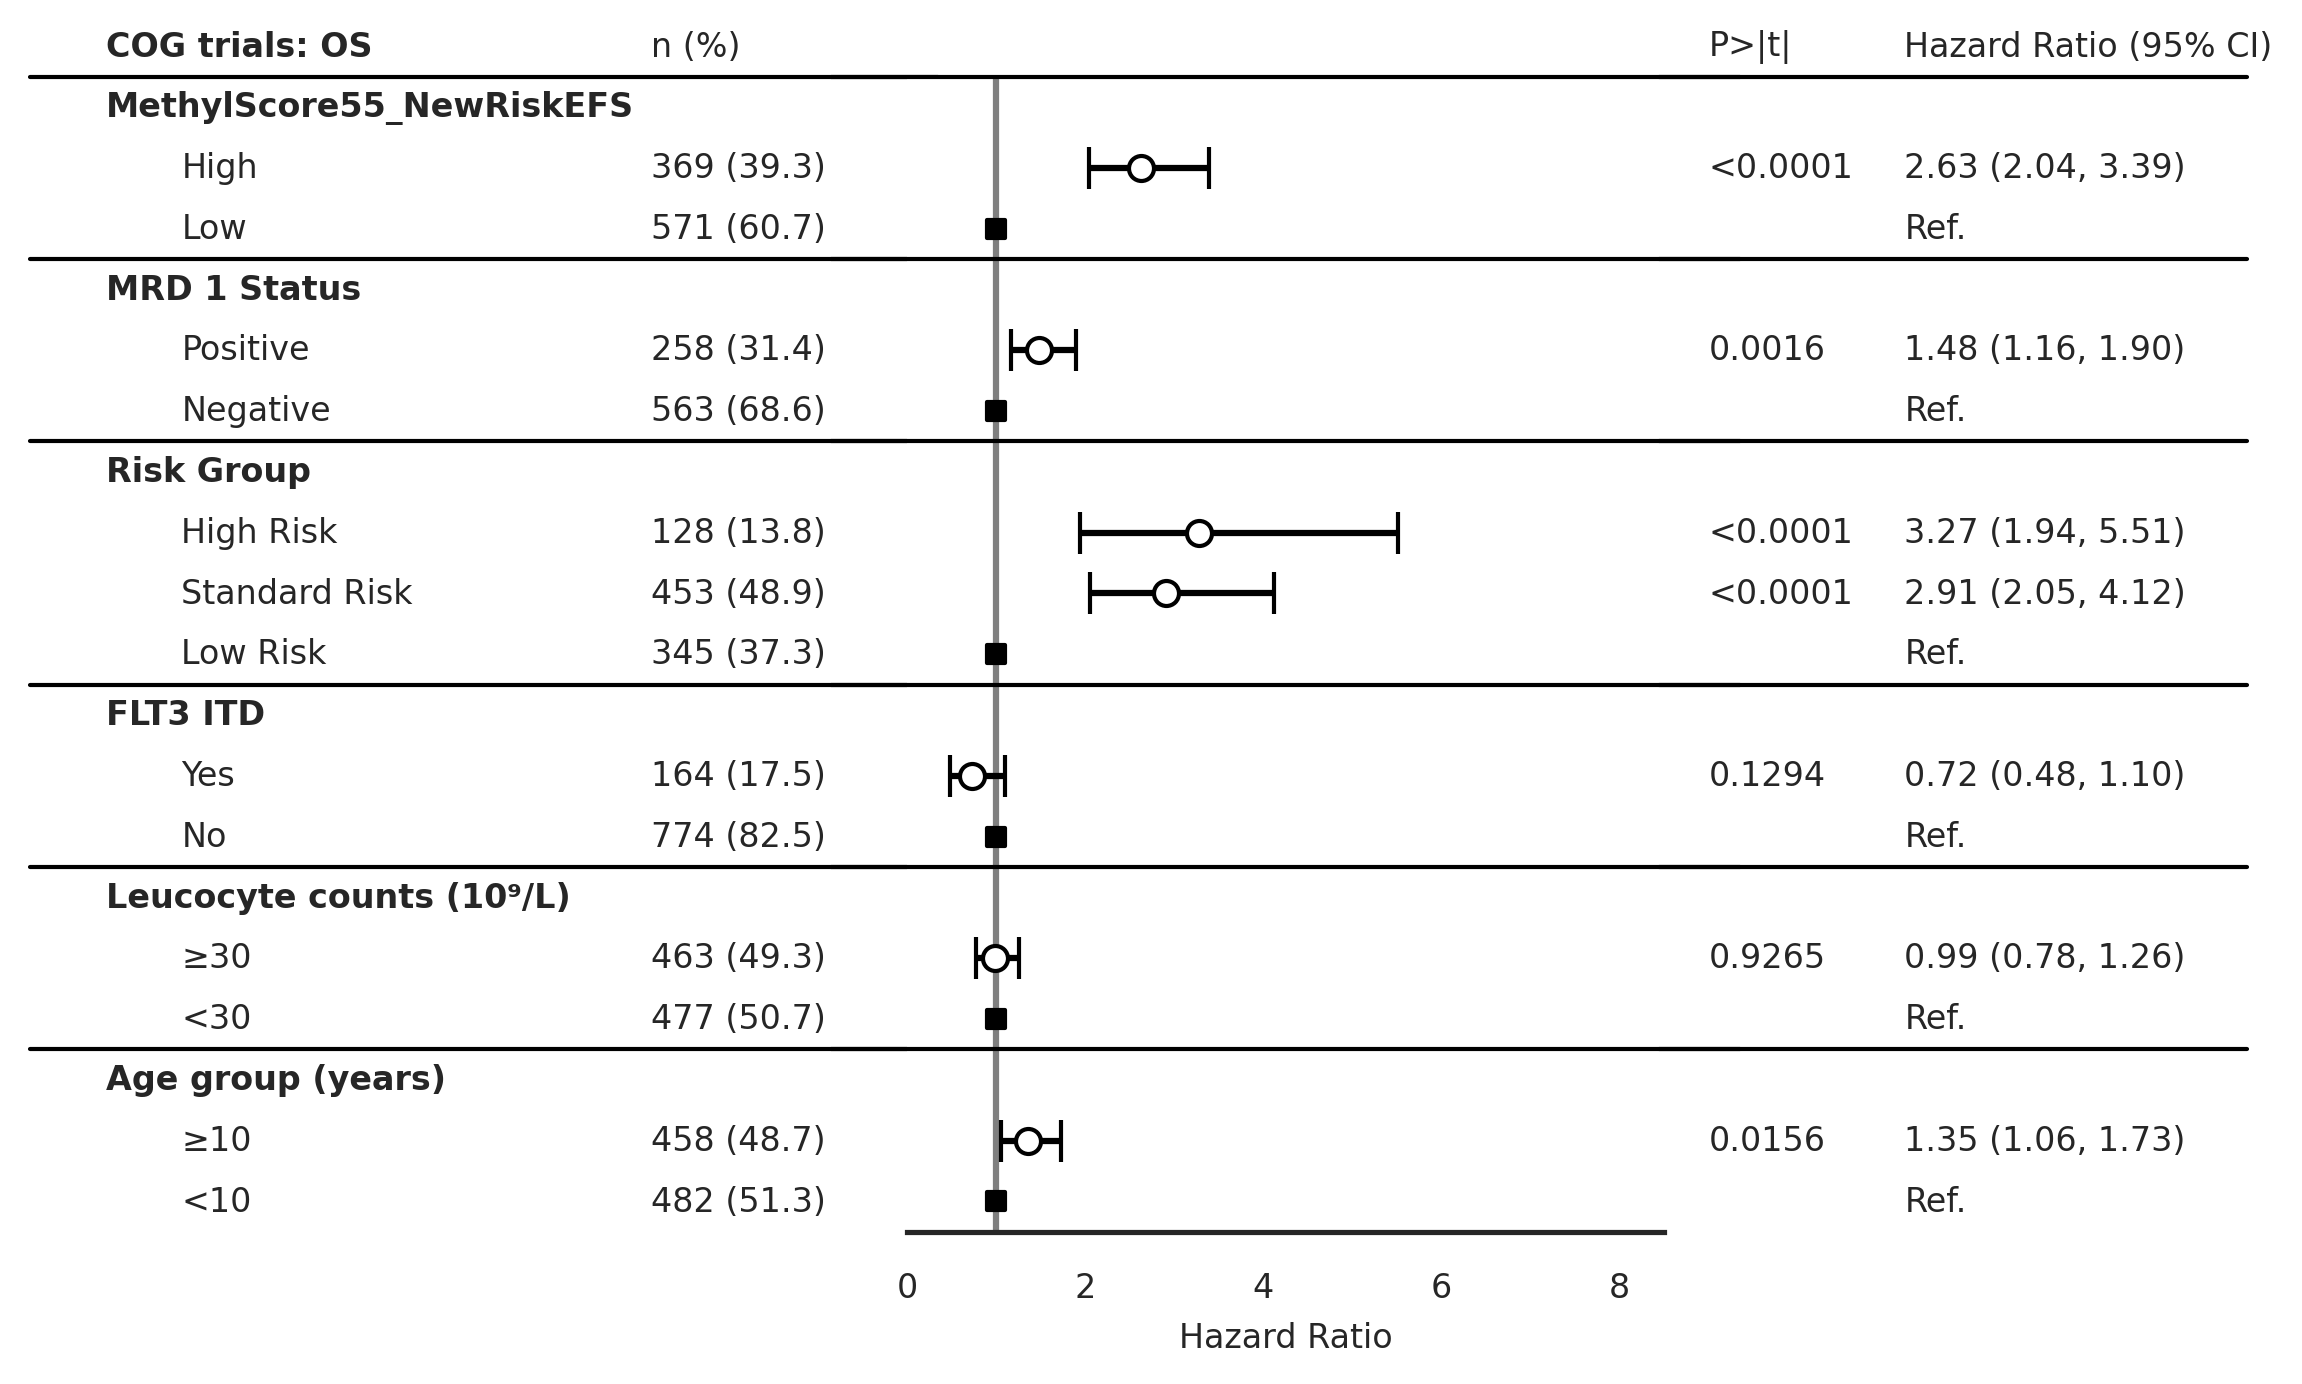

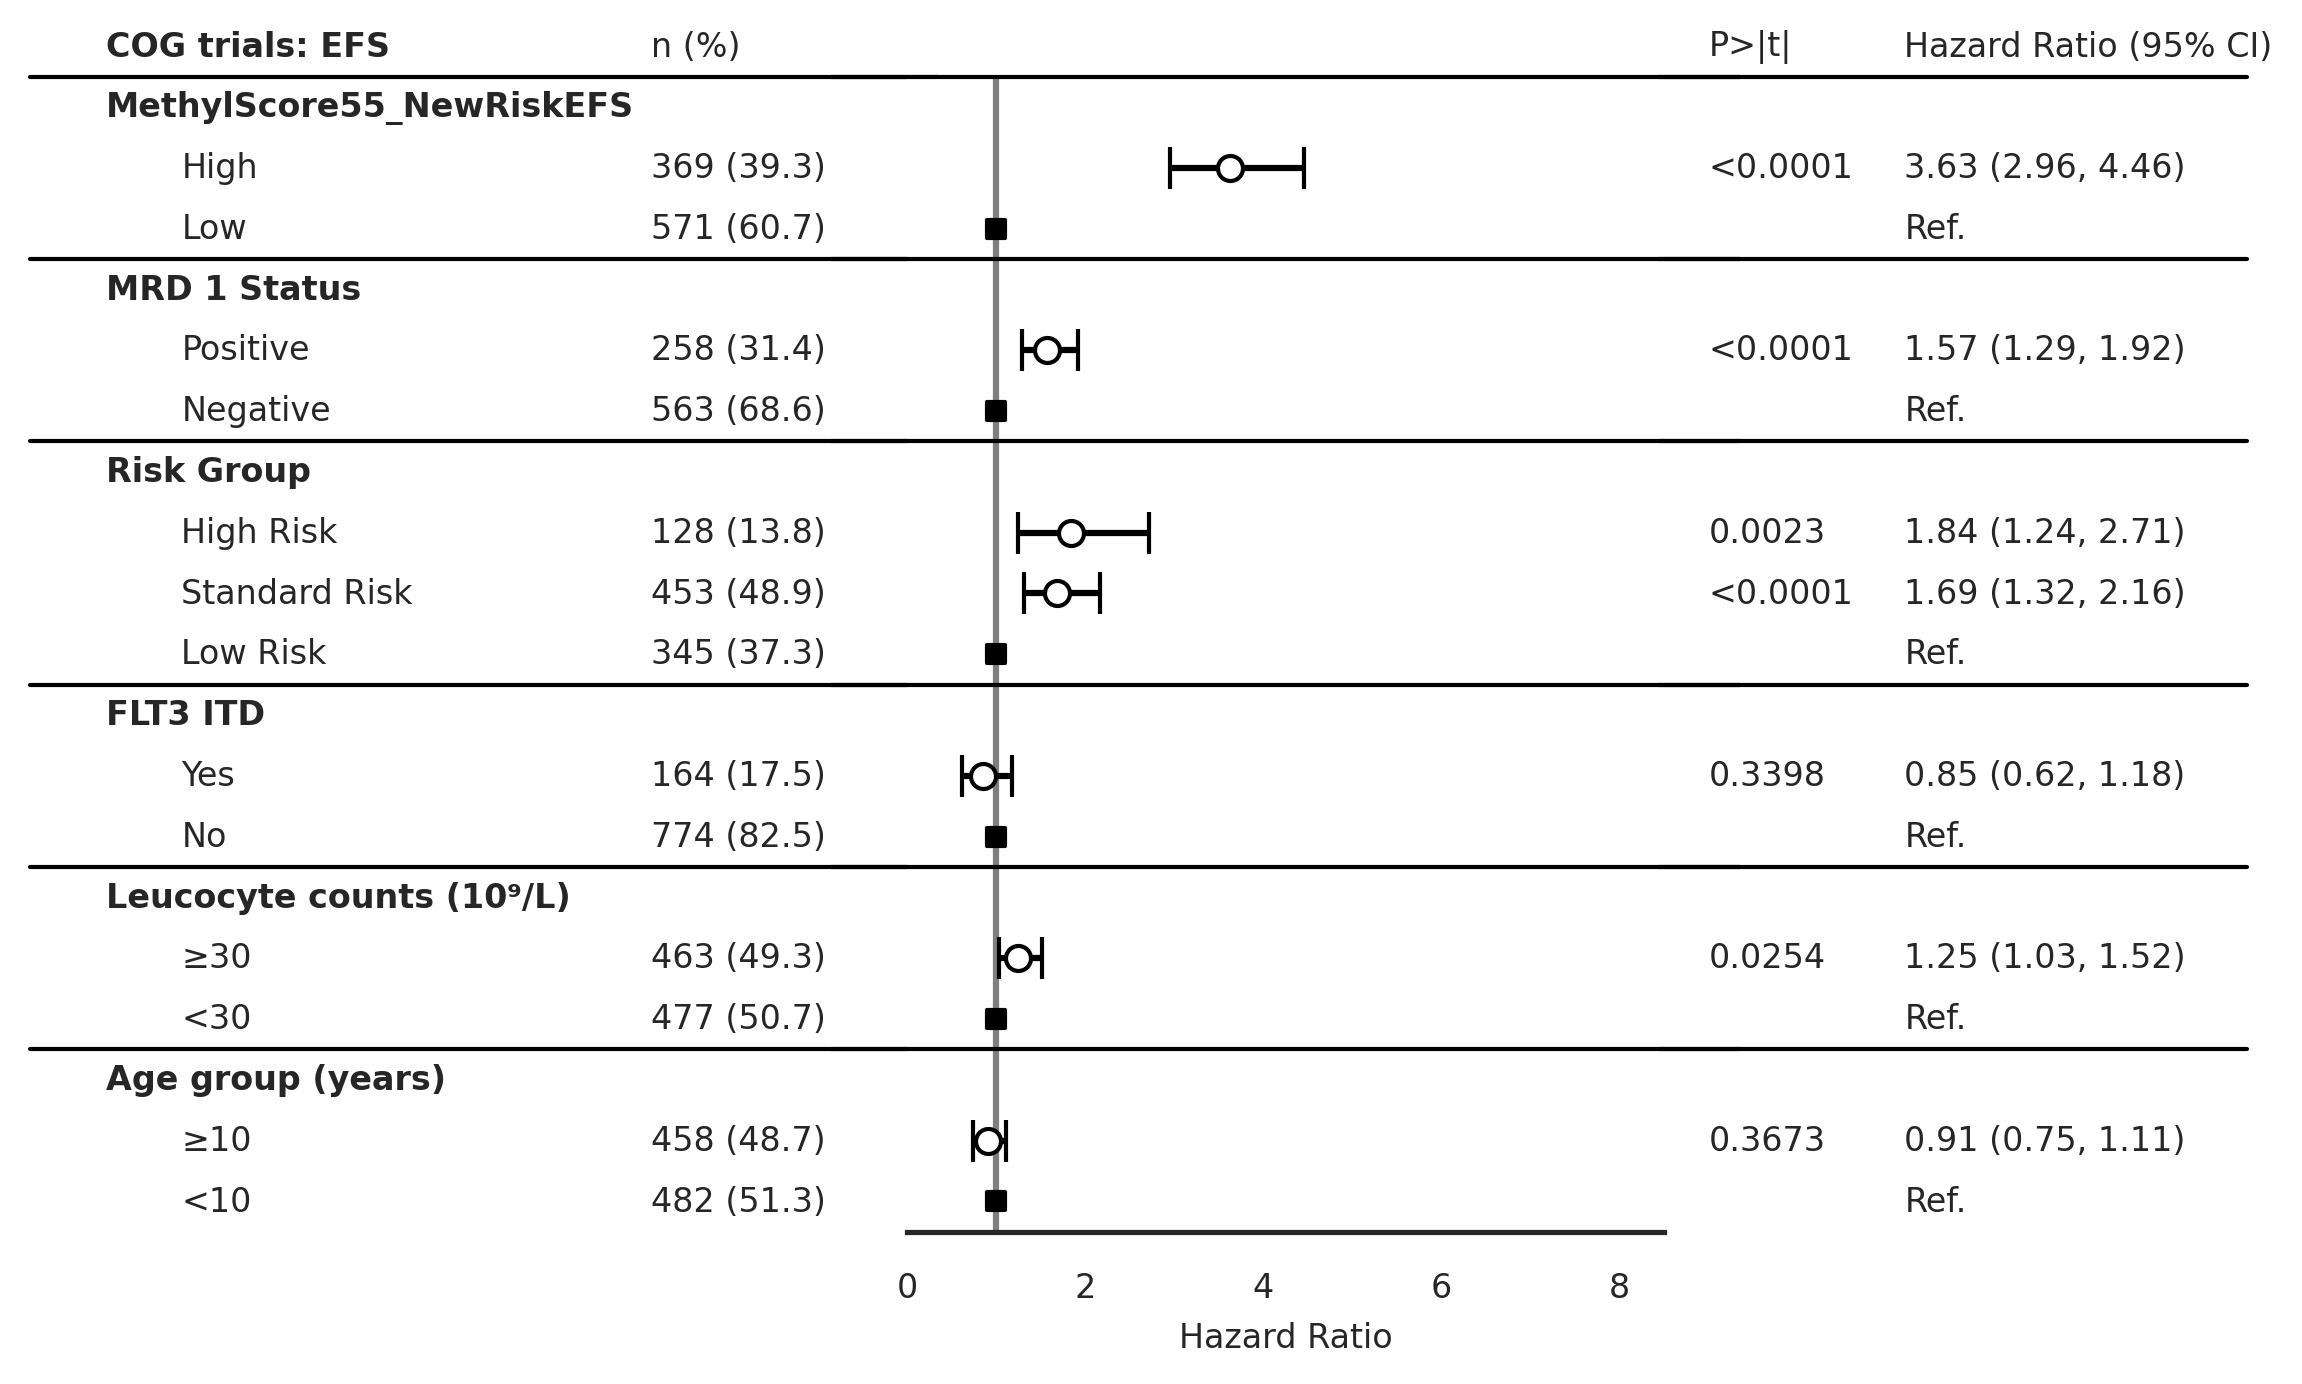

In [13]:

draw_forest_plot(time='os.time',
                    event='os.evnt',
                    df=df,
                    trialname='COG trials:',
                    scorename=score_name,
                    save_plot=False)

draw_forest_plot(time='efs.time',
                    event='efs.evnt',
                    df=df,
                    trialname='COG trials:',
                    scorename=score_name,
                    save_plot=False)

#### Without MRD 1

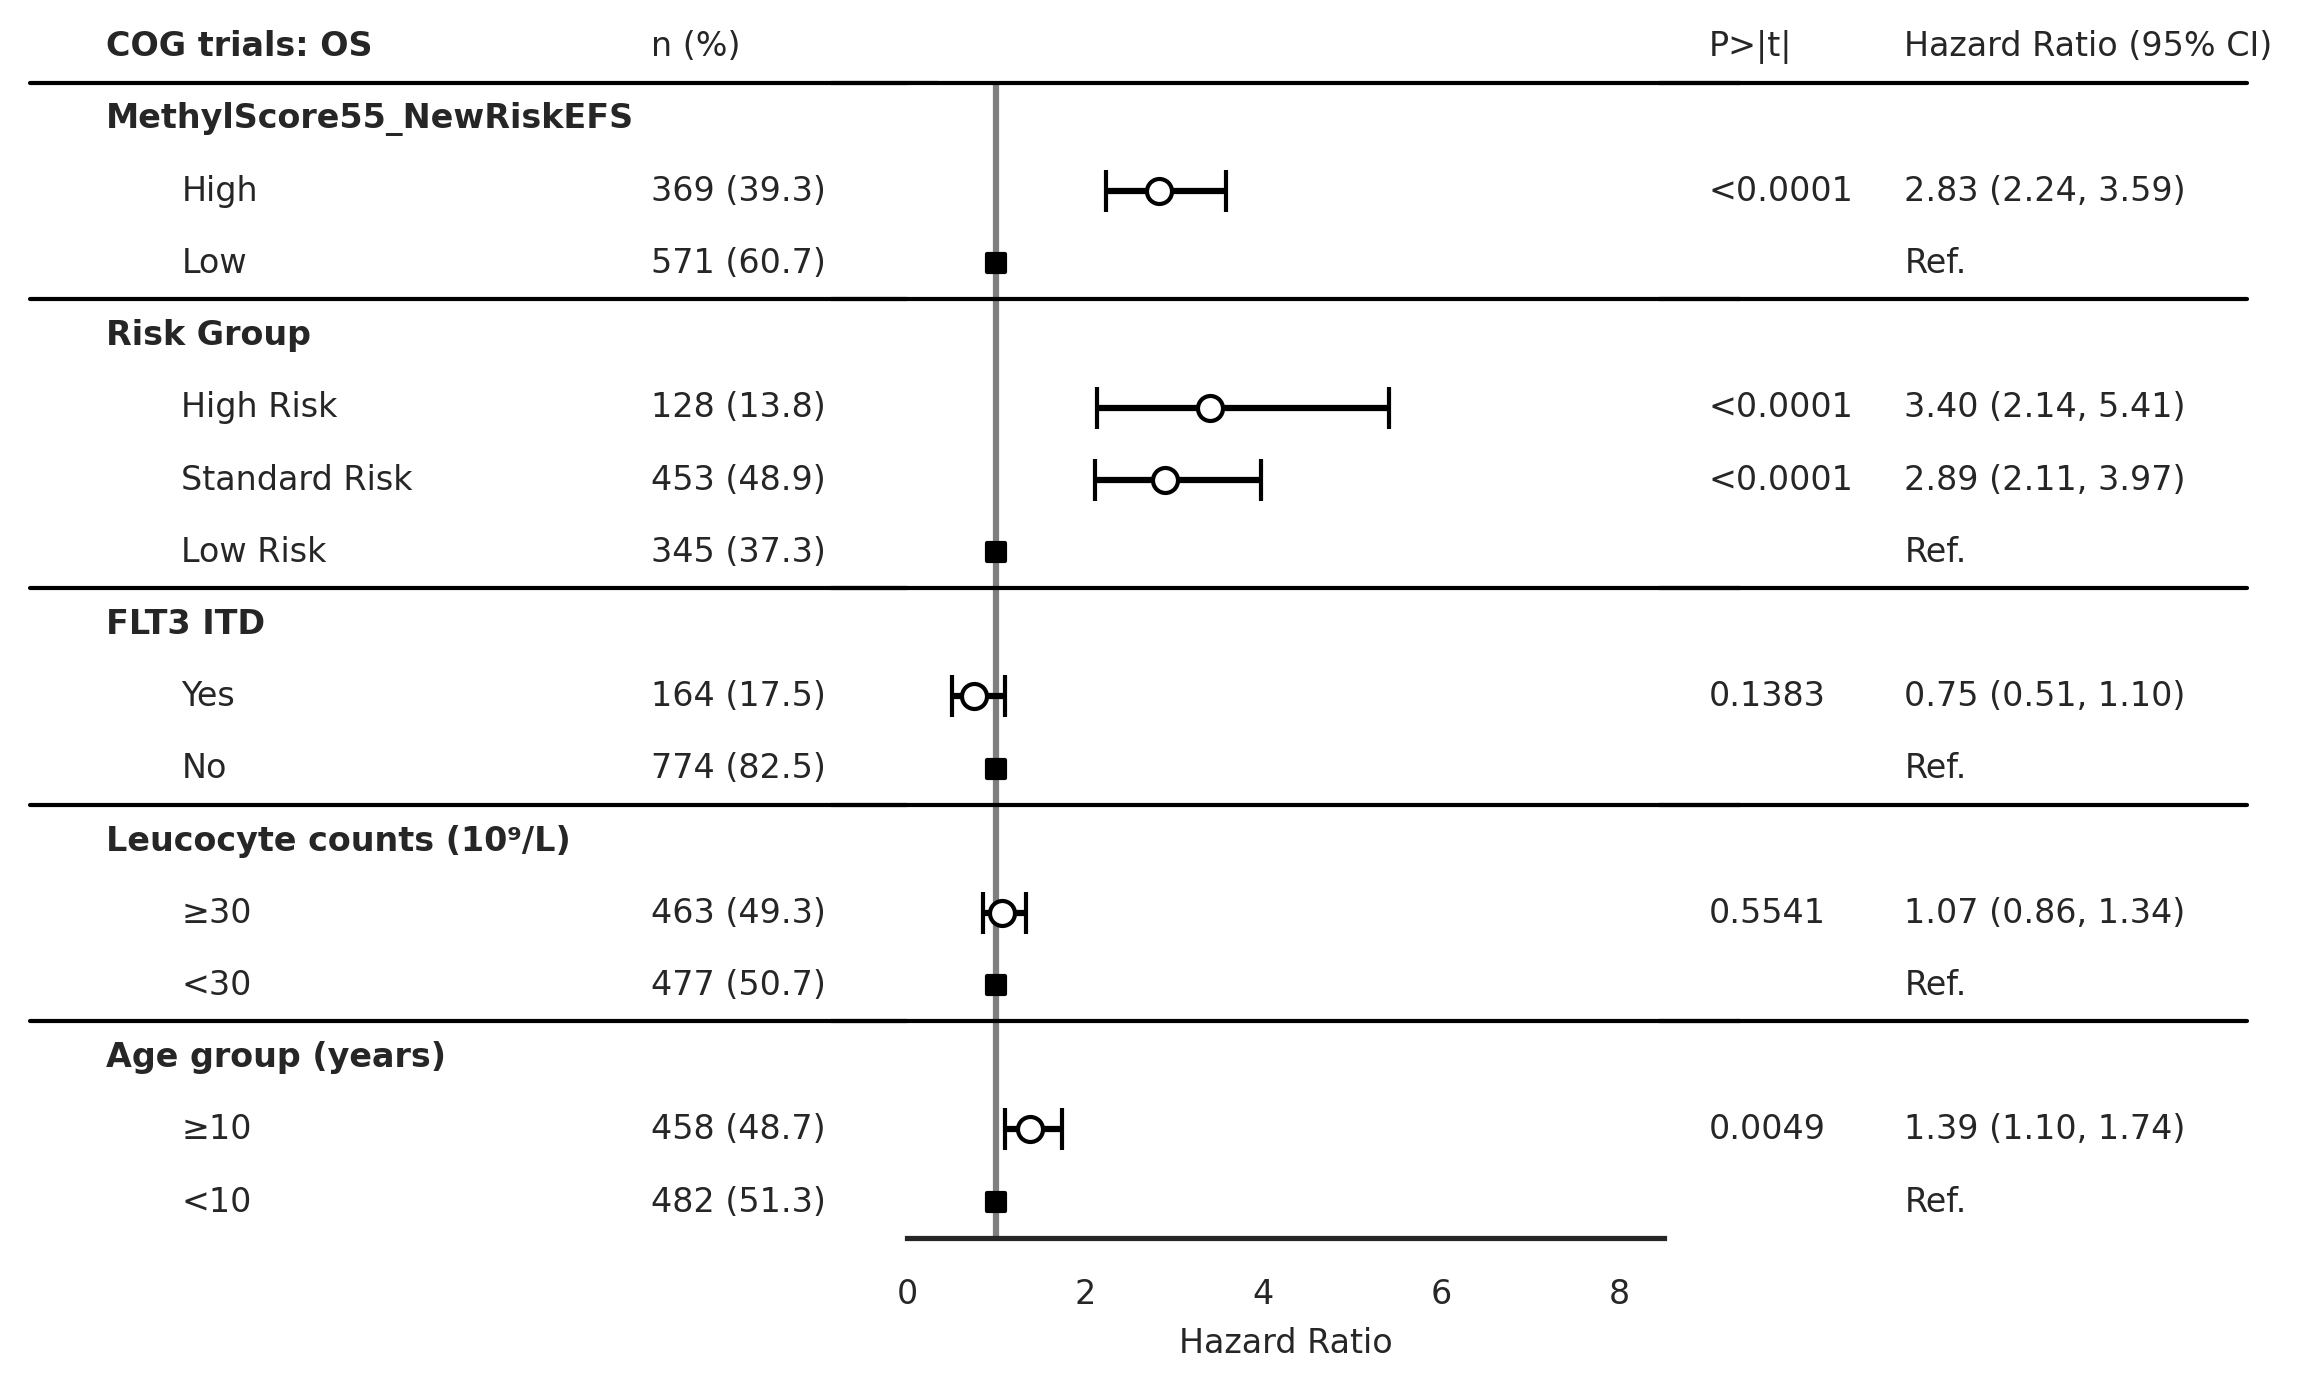

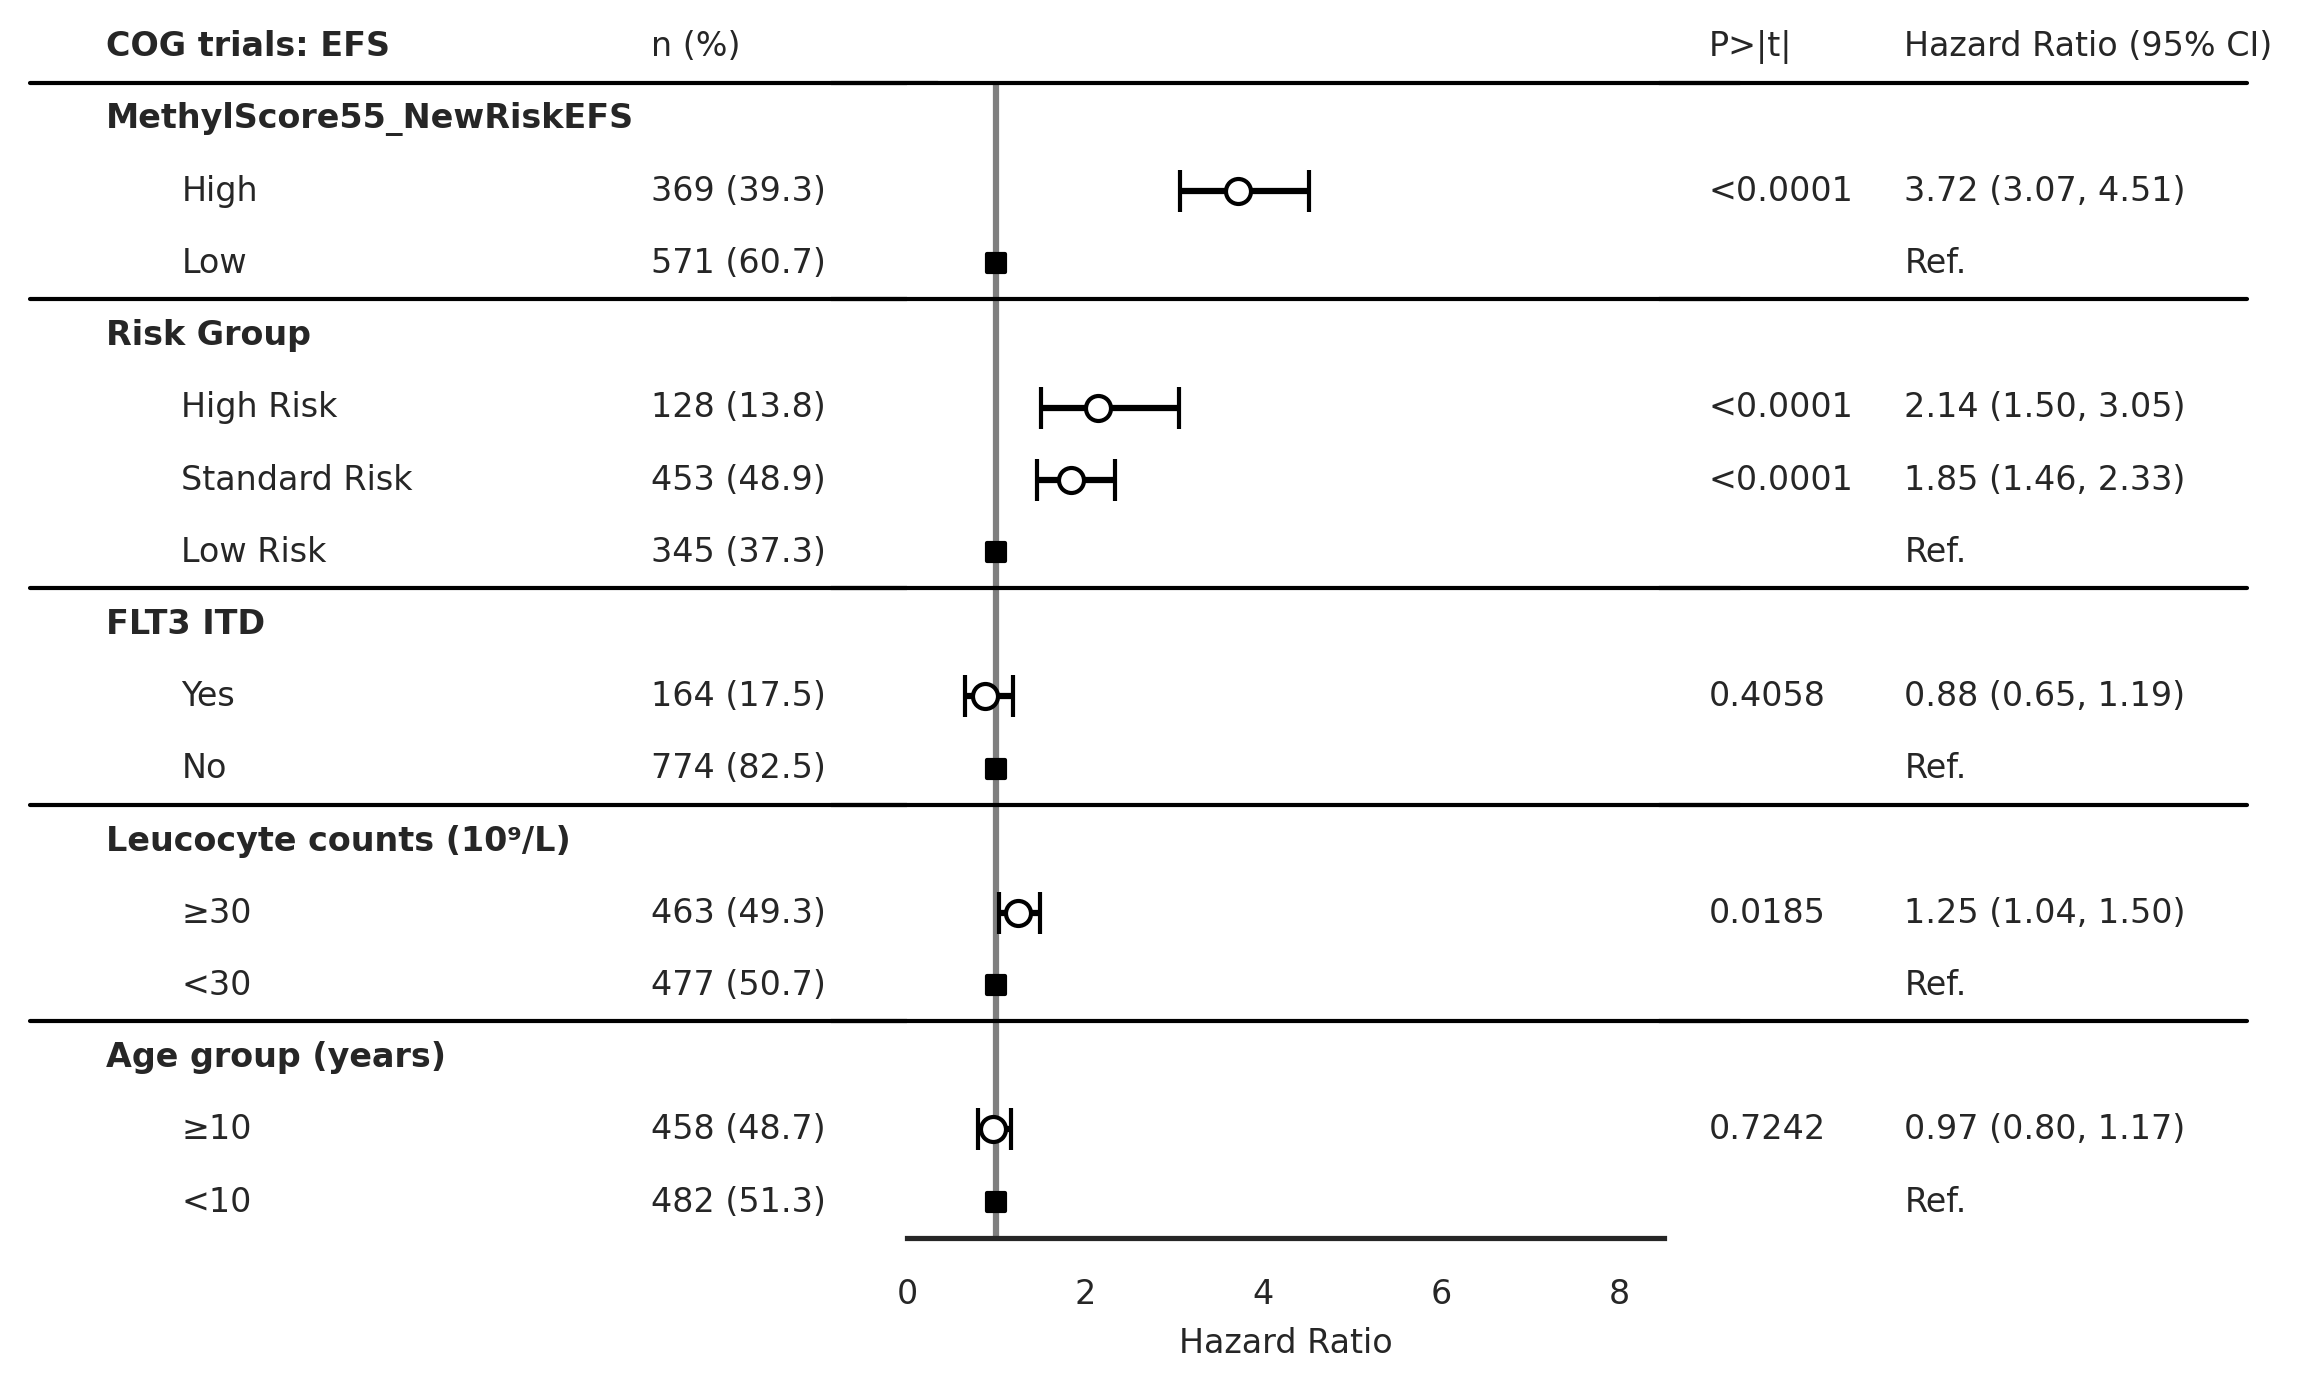

In [14]:
draw_forest_plot_noMRD(time='os.time',
                    event='os.evnt',
                    df=df,
                    trialname='COG trials:',
                    scorename=score_name,
                    save_plot=False)

draw_forest_plot_noMRD(time='efs.time',
                    event='efs.evnt',
                    df=df,
                    trialname='COG trials:',
                    scorename=score_name,
                    save_plot=False)

### ROC AUC

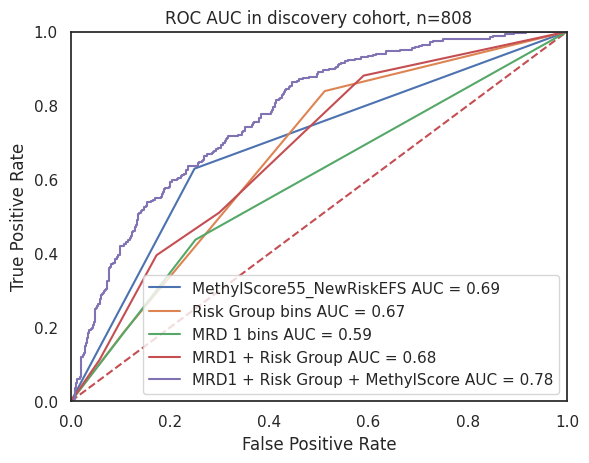

In [15]:
# Your current preprocessing
df['Risk Group bins'] = df['Risk Group'].replace({'Low Risk':0, 'Standard Risk':0.5, 'High Risk':1})
df['MRD 1 bins'] = df['MRD 1 Status'].replace({'Negative':0, 'Positive':1})
df2 = df[['os.evnt', score_name + '_cat_bin', 'Risk Group bins', 'MRD 1 bins']].dropna()

# rename column `MethylScoreAML_Px_cat_bin` to `MethylScoreAML Px`
df2 = df2.rename(columns={score_name + '_cat_bin':score_name})

# Add new columns based on standardized values
df2['MRD1 + Risk Group'] = df['MRD 1 bins'] + df['Risk Group bins']
df2['MRD1 + Risk Group + MethylScore'] = df['MRD 1 bins'] + df['Risk Group bins'] + df[score_name]


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def plot_roc_auc(df, score_columns, outcome_column, trial_name='discovery cohort'):
    """
    Plots the ROC AUC curves for multiple models given a dataframe and multiple score columns.
    
    Parameters:
    - df (pd.DataFrame): Dataframe containing the score and outcome columns.
    - score_columns (list of str): List of names of columns that contain the scores.
    - outcome_column (str): The name of the column that contains the true outcomes.
    
    Returns:
    None
    """
    
    plt.figure()
    plt.title('ROC AUC in ' + trial_name + ', n={}'.format(len(df)))
    
    # plot random guessing line
    plt.plot([0, 1], [0, 1], 'r--')

    # binarize the outcome variable
    lb = LabelBinarizer()
    lb.fit(df[outcome_column])
    y = lb.transform(df[outcome_column])
    
    # Loop over score_columns to plot multiple ROC curves
    for score_column in score_columns:
        
        # calculate the fpr and tpr for all thresholds of the classification
        fpr, tpr, threshold = roc_curve(y, df[score_column])
        roc_auc = auc(fpr, tpr)
        
        # plot ROC curve for this score_column
        plt.plot(fpr, tpr, label=f'{score_column} AUC = %0.2f' % roc_auc)

    # set x and y limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # set x and y labels
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # add legend
    plt.legend(loc='lower right')
    plt.show()

# Example Usage:
score_columns = [score_name, 'Risk Group bins', 'MRD 1 bins', 'MRD1 + Risk Group', 'MRD1 + Risk Group + MethylScore']
outcome_column = 'os.evnt'
plot_roc_auc(df2, score_columns, outcome_column)



### Box Plots

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High Risk vs. Standard Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:8.541e-01 Stat=1.144e+00
Standard Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:4.213e-27 Stat=1.184e+02
High Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:4.257e-18 Stat=7.737e+01


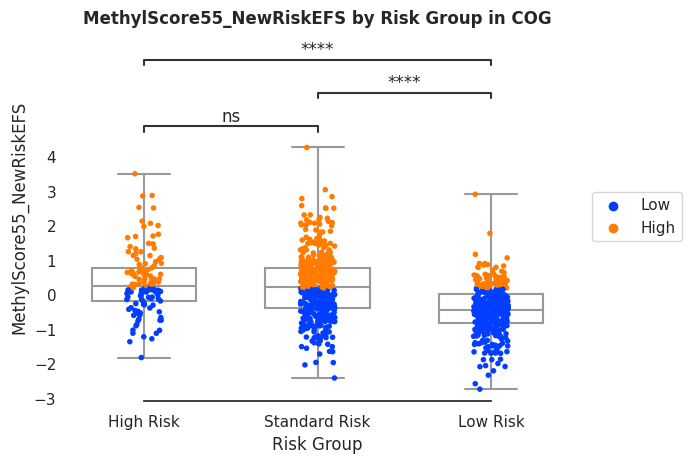

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Positive vs. Negative: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:5.766e-09 Stat=3.391e+01


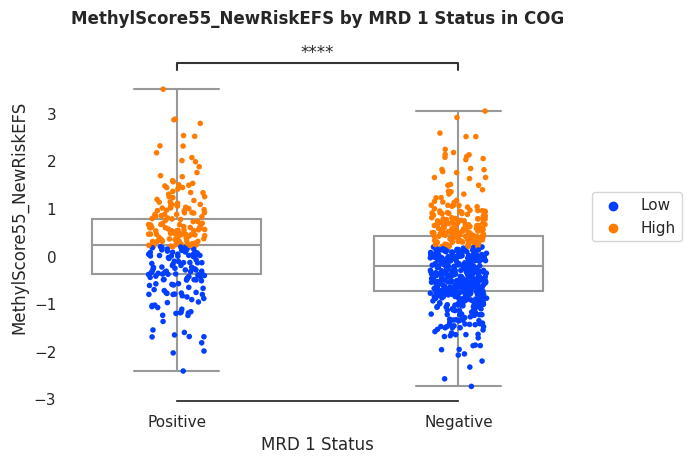

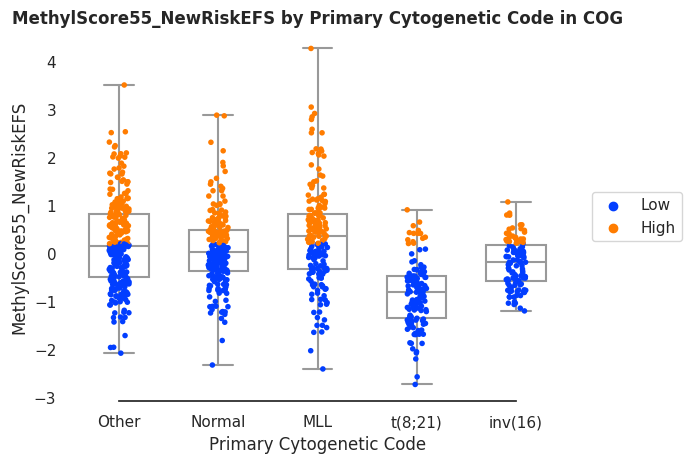

In [16]:
draw_boxplot(df=discovery_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=discovery_clinical_data,x='MRD 1 Status', y=score_name,
                order=['Positive','Negative'],
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=discovery_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

### Stacked Bar Plots

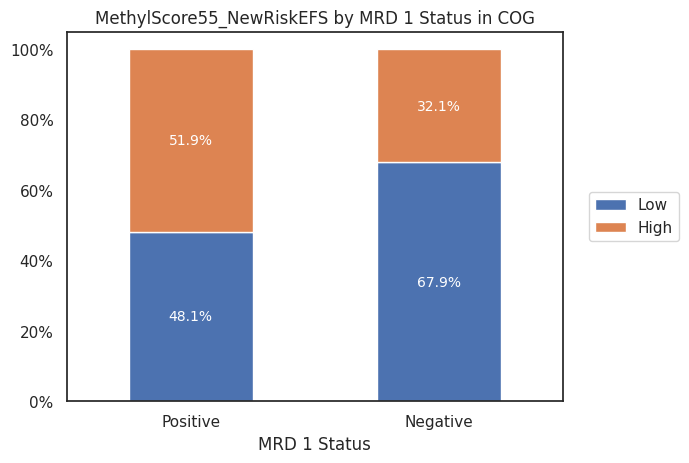

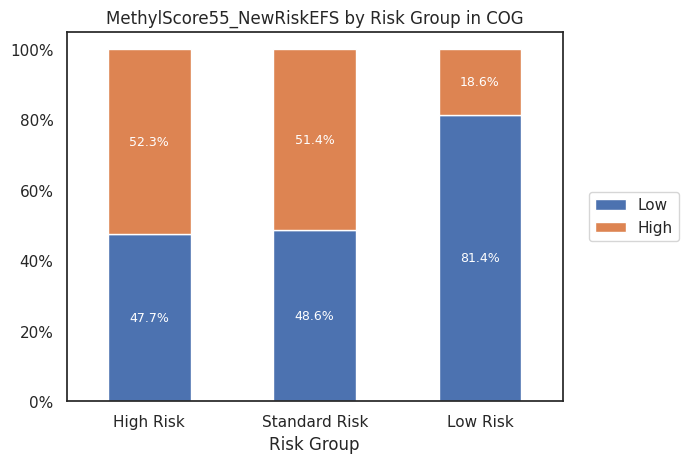

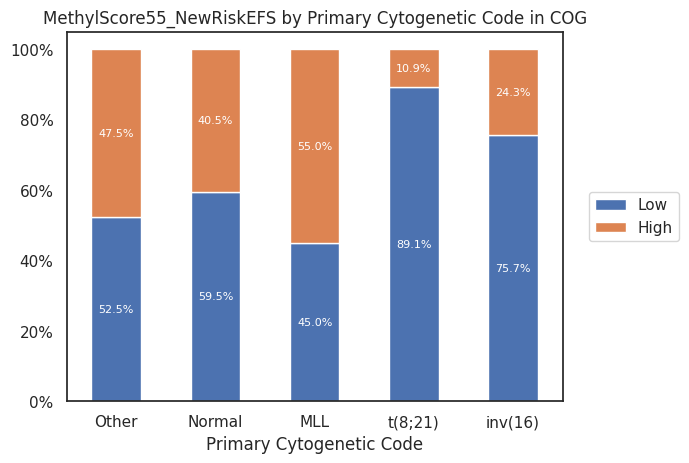

In [17]:
draw_stacked_barplot(df=discovery_clinical_data,x='MRD 1 Status', y=score_name,
             order=['Positive','Negative'],
             trialname='COG', hue=score_name + ' Categorical',
             save_plot=False, figsize=None)

draw_stacked_barplot(df=discovery_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=9)

draw_stacked_barplot(df=discovery_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=8)



### Patient Characteristics Table

#### Overall study population

In [18]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

discovery_clinical_data['Age (years)'] = discovery_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(discovery_clinical_data, columns,
                        overall=False, missing=True,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']})

# mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_discovery_cohort.csv')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','Discovery Cohort','Low','p-value','Statistical Test'])

MethylScore55_NewRiskEFS,,Missing,Discovery Cohort
n,,,940
"Age (years), mean (SD)",,0,9.4 (6.3)
"Age group (years), n (%)",≥10,0,458 (48.7)
,<10,,482 (51.3)
"Sex, n (%)",Female,0,466 (49.6)
,Male,,474 (50.4)
"Race or ethnic group, n (%)",White,64,692 (79.0)
,Black or African American,,102 (11.6)
,Asian,,43 (4.9)
,American Indian or Alaska Native,,5 (0.6)


#### By MethylScore category

In [19]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

discovery_clinical_data['Age (years)'] = discovery_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(discovery_clinical_data, columns,
                        overall=False, missing=True,
                        pval=True, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                        groupby=score_name + ' Categorical')

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_discovery_methylscoreaml_px.csv')
mytable_cog.to_excel('../data/tableone_discovery_methylscoreaml_px.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','High','Low','p-value','Statistical Test'])

MethylScore55_NewRiskEFS,,Missing,High,Low,p-value,Statistical Test
n,,,571,369,,
"Age (years), mean (SD)",,0,9.4 (6.3),9.3 (6.3),0.810,Two Sample T-test
"Age group (years), n (%)",≥10,0,273 (47.8),185 (50.1),0.529,Chi-squared
,<10,,298 (52.2),184 (49.9),,
"Sex, n (%)",Female,0,293 (51.3),173 (46.9),0.208,Chi-squared
,Male,,278 (48.7),196 (53.1),,
"Race or ethnic group, n (%)",White,64,423 (79.4),269 (78.4),0.139,Chi-squared (warning: expected count < 5)
,Black or African American,,52 (9.8),50 (14.6),,
,Asian,,29 (5.4),14 (4.1),,
,American Indian or Alaska Native,,4 (0.8),1 (0.3),,


## Fetch gene annotation

In [20]:
# Load manifest
zhou2016_probes = pd.read_csv(zhou2016_probes_path,sep='\t',
                    index_col=0)[['chrm','start', 'end', 'GeneNames','GeneClasses','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
mean_coefs_genes = zhou2016_probes.loc[list(ewas_top_cpgs.columns)]\
                                    .join(mean_coefs.to_frame('MethylScore Coefficients'), how='left')\
                                    .sort_values(by='MethylScore Coefficients', ascending=False)

# `GeneNames`, `GeneClasses`, and `TranscriptIDs` columns contain multiple genes separated by `;` so we need to keep only the unique ones
mean_coefs_genes['GeneNames'] = mean_coefs_genes['GeneNames'].apply(lambda x: ';'.join(set(x.split(';'))))
mean_coefs_genes['GeneClasses'] = mean_coefs_genes['GeneClasses'].apply(lambda x: ';'.join(set(x.split(';'))))

# Transform `GeneNames` values separated by `;` into a list
mean_coefs_genes['GeneNames'] = mean_coefs_genes['GeneNames'].apply(lambda x: x.split(';'))

# If there are multiple genes in `GeneNames` or `GeneClasses`, we will add one row for each gene
mean_coefs_genes = mean_coefs_genes.explode('GeneNames')

# Save the dataframe to a CSV file
mean_coefs_genes.to_excel('../data/MethylScoreAML_Px_167_cpg_genes.xlsx')
mean_coefs_genes.to_csv(output_path + 'multivariate_cox_lasso/methylScore_coxph_167_cpg_signature.csv')


from itables import show

show(mean_coefs_genes, classes="display nowrap cell-border")


## Watermark

In [21]:
%load_ext watermark

In [22]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

pandas         : 2.0.2
seaborn        : 0.12.2
matplotlib     : 3.7.1
tableone       : 0.7.12
sklearn        : 1.2.2
lifelines      : 0.27.7
statannotations: 0.5.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

